# gradient map

inspiration:
https://manifold.net/doc/mfd8/displaying_data_in_a_gradient_map.htm

data source:
https://newatlas.com/nasa-climate-change-dataset-2100/37943/


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [4]:
def sample_random_points(img, num_samples):
    height, width = img.shape[:2]

    # Start with the four corners
    corner_positions = np.array([
        [0, 0],           # top-left
        [width-1, 0],     # top-right
        [0, height-1],    # bottom-left
        [width-1, height-1]  # bottom-right
    ])
    
    # Generate remaining random positions
    remaining_samples = num_samples - 4
    x_coords = np.random.randint(0, width, remaining_samples)
    y_coords = np.random.randint(0, height, remaining_samples)
    random_positions = np.column_stack((x_coords, y_coords))
    
    # Combine corner and random positions
    positions = np.vstack((corner_positions, random_positions))
    
    # Get RGB values at these coordinates
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    colors = img[positions[:, 1], positions[:, 0]]
    
    return positions, colors


num_samples = 5000
dataimg_path = "images/temperature.png"
figsize = (10, 5)


dataimg = cv2.imread(dataimg_path)
height, width = dataimg.shape[:2]

# sample random points
positions, colors = sample_random_points(dataimg, num_samples)


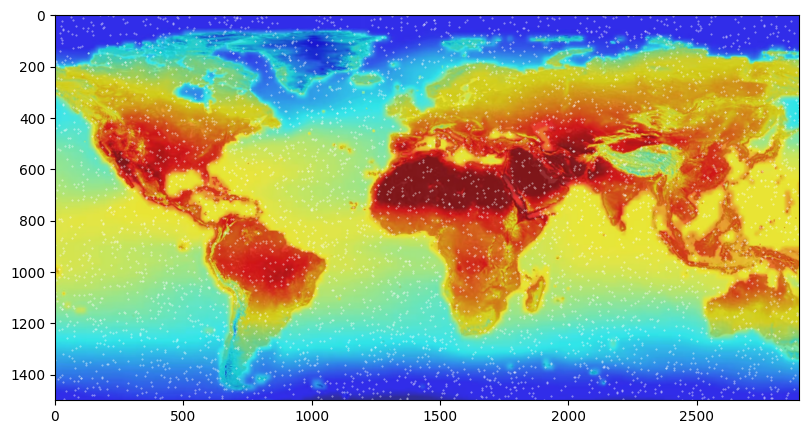

In [5]:
plt.figure(figsize=figsize)
plt.imshow(cv2.cvtColor(dataimg, cv2.COLOR_BGR2RGB))
plt.scatter(positions[:, 0], positions[:, 1], c='white', alpha=0.5, s=0.2)
plt.show()

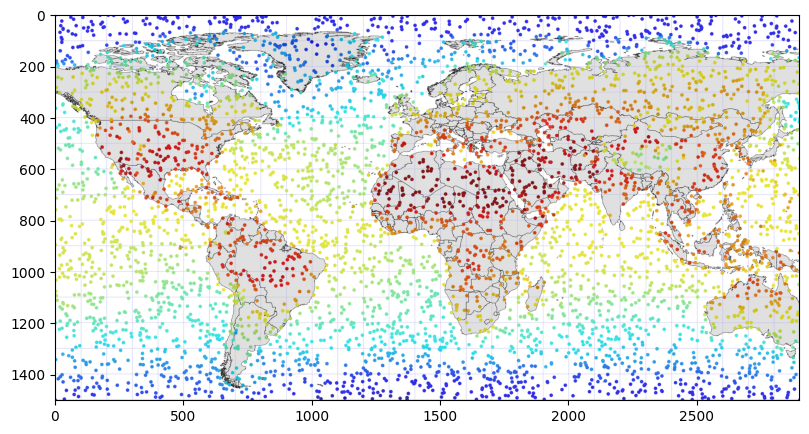

In [6]:
mapimg_path = "images/map.png"
mapimg = cv2.imread(mapimg_path)

for i in range(num_samples):
    # Convert RGB to BGR by reversing the color array
    bgr_color = colors[i][::-1].tolist()
    cv2.circle(mapimg, tuple(positions[i]), 7, bgr_color, -1)


plt.figure(figsize=figsize)
plt.imshow(cv2.cvtColor(mapimg, cv2.COLOR_BGR2RGB))

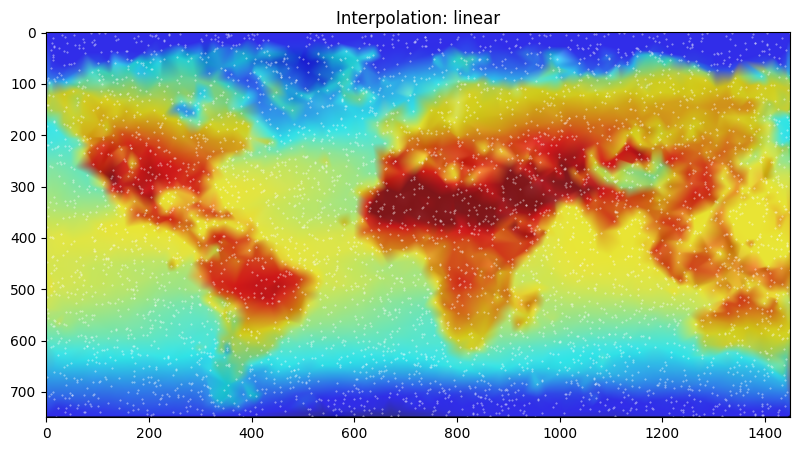

In [7]:
grid_width = width // 2
grid_height = height // 2

method = 'linear' # 'nearest', 'linear', 'cubic'

# Create regular grid with proper scaling to match position coordinates
x = np.linspace(0, width, grid_width)
y = np.linspace(0, height, grid_height)
grid_x, grid_y = np.meshgrid(x, y)

# Interpolate each color channel separately
grid_r = griddata(positions, colors[:, 0], (grid_x, grid_y), method=method)
grid_g = griddata(positions, colors[:, 1], (grid_x, grid_y), method=method)
grid_b = griddata(positions, colors[:, 2], (grid_x, grid_y), method=method)

# Stack the color channels
grid_bgr = np.dstack((grid_b, grid_g, grid_r))

# Fill NaN values with 0, clip values and convert to uint8
grid_bgr = np.nan_to_num(grid_bgr, nan=0.0)
grid_bgr = np.clip(grid_bgr, 0, 255).astype(np.uint8)

kernel_size = 9
# grid_bgr = cv2.GaussianBlur(grid_bgr, (kernel_size, kernel_size), 0)
grid_bgr = cv2.medianBlur(grid_bgr, kernel_size)

cv2.imwrite("output/interpolated.png", grid_bgr)

# Rest of the plotting code remains the same
plt.figure(figsize=figsize)
plt.imshow(cv2.cvtColor(grid_bgr, cv2.COLOR_BGR2RGB))

positions_x = positions[:, 0]/width * grid_width
positions_y = positions[:, 1]/height * grid_height
plt.scatter(positions_x, positions_y, c='white', alpha=0.5, s=0.2)
plt.title(f'Interpolation: {method}')
plt.show()
